[![Fixel Algorithms](https://i.imgur.com/AqKHVZ0.png)](https://fixelalgorithms.gitlab.io/)

# MultiDimensional Scaling (MDS)

> Notebook by:
> - Royi Avital RoyiAvital@fixelalgorithms.com

## Revision History

| Version | Date       | User        |Content / Changes                                                   |
|---------|------------|-------------|--------------------------------------------------------------------|
| 1.0.000 | 13/04/2024 | Royi Avital | First version                                                      |

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/AIProgram/2024_02/0066DimensionalityReductionMDS.ipynb)

In [1]:
# Import Packages

# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Machine Learning
from sklearn.datasets import make_s_curve
from sklearn.manifold import MDS

# Miscellaneous
import math
import os
from platform import python_version
import random
import timeit

# Typing
from typing import Callable, Dict, List, Optional, Self, Set, Tuple, Union

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter
from IPython import get_ipython
from IPython.display import Image
from IPython.display import display
from ipywidgets import Dropdown, FloatSlider, interact, IntSlider, Layout, SelectionSlider
from ipywidgets import interact

## Notations

* <font color='red'>(**?**)</font> Question to answer interactively.
* <font color='blue'>(**!**)</font> Simple task to add code for the notebook.
* <font color='green'>(**@**)</font> Optional / Extra self practice.
* <font color='brown'>(**#**)</font> Note / Useful resource / Food for thought.

Code Notations:

```python
someVar    = 2; #<! Notation for a variable
vVector    = np.random.rand(4) #<! Notation for 1D array
mMatrix    = np.random.rand(4, 3) #<! Notation for 2D array
tTensor    = np.random.rand(4, 3, 2, 3) #<! Notation for nD array (Tensor)
tuTuple    = (1, 2, 3) #<! Notation for a tuple
lList      = [1, 2, 3] #<! Notation for a list
dDict      = {1: 3, 2: 2, 3: 1} #<! Notation for a dictionary
oObj       = MyClass() #<! Notation for an object
dfData     = pd.DataFrame() #<! Notation for a data frame
dsData     = pd.Series() #<! Notation for a series
hObj       = plt.Axes() #<! Notation for an object / handler / function handler
```

### Code Exercise

 - Single line fill

 ```python
 vallToFill = ???
 ```

 - Multi Line to Fill (At least one)

 ```python
 # You need to start writing
 ????
 ```

 - Section to Fill

```python
#===========================Fill This===========================#
# 1. Explanation about what to do.
# !! Remarks to follow / take under consideration.
mX = ???

???
#===============================================================#
```

In [2]:
# Configuration
# %matplotlib inline

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

# Matplotlib default color palette
lMatPltLibclr = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# sns.set_theme() #>! Apply SeaBorn theme

runInGoogleColab = 'google.colab' in str(get_ipython())


In [3]:
# Constants

FIG_SIZE_DEF    = (8, 8)
ELM_SIZE_DEF    = 50
CLASS_COLOR     = ('b', 'r')
EDGE_COLOR      = 'k'
MARKER_SIZE_DEF = 10
LINE_WIDTH_DEF  = 2


In [4]:
# Courses Packages
import sys
sys.path.append('../')
sys.path.append('../../')
sys.path.append('../../../')
from utils.DataVisualization import PlotScatterData, PlotScatterData3D


In [5]:
# General Auxiliary Functions


## Dimensionality Reduction by MDS

The MDS is a non linear transformation from $\mathbb{R}^{D} \to \mathbb{R}^{d}$ where $d \ll D$.  
Given a set $\mathcal{X} = {\left\{ \boldsymbol{x}_{i} \in \mathbb{R}^{D} \right\}}_{i = 1}^{n}$ is builds the set $\mathcal{Z} = {\left\{ \boldsymbol{z}_{i} \in \mathbb{R}^{d} \right\}}_{i = 1}^{n}$ such that the distance matrices of each set are similar.

In this notebook:

 - We'll implement the classic MDS.
 - We'll use the data set to show the effects of dimensionality reduction.  

In [6]:
# Parameters

# Data
numSamples = 1000

# Model
lowDim = 2


## Generate / Load Data

In this notebook we'll use [SciKit Learn's `make_s_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_s_curve.html) to generated data.  

In [7]:
# Generate Data
mX, vC = make_s_curve(numSamples) #<! Results are random beyond the noise

print(f'The features data shape: {mX.shape}')
print(f'The features data type: {mX.dtype}')


The features data shape: (1000, 3)
The features data type: float64


### Plot Data

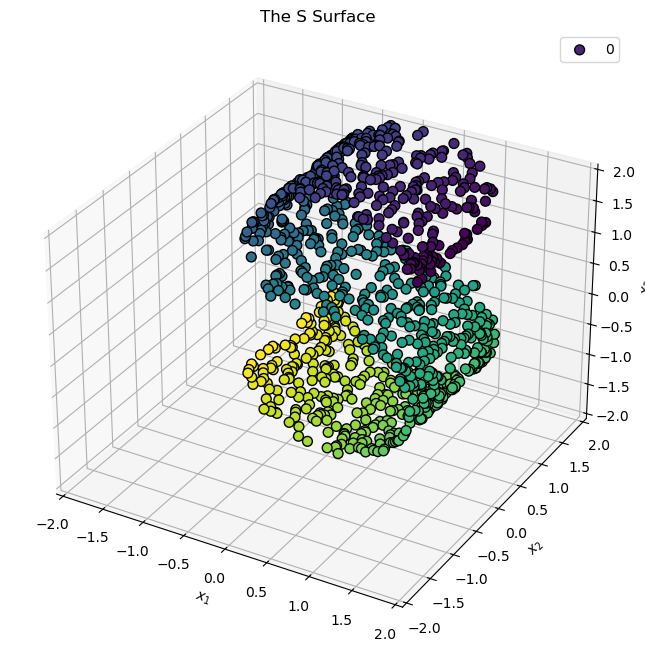

In [8]:
# Plot the Data

hA = PlotScatterData3D(mX, vC = vC)
hA.set_xlim([-2, 2])
hA.set_ylim([-2, 2])
hA.set_zlim([-2, 2])
hA.set_title('The S Surface')

plt.show()

## Applying Dimensionality Reduction - MDS

In this section we'll implement the Classic MDs:

### Non Metric (Classic) MDS

$$\min_{\left\{ \boldsymbol{z}_{i}\in\mathbb{R}^{d}\right\} }\sum_{i=1}^{N}\sum_{j=1}^{N}\left(\boldsymbol{K}_{x}\left[i,j\right]-\left\langle \boldsymbol{z}_{i},\boldsymbol{z}_{j}\right\rangle \right)^{2}$$
1. **set** $\boldsymbol{K}_{x}=-\frac{1}{2}\boldsymbol{J}\boldsymbol{D}_{x}\boldsymbol{J}$  
where $\boldsymbol{J}=\left(\boldsymbol{I}-\frac{1}{N}\boldsymbol{1}\boldsymbol{1}^{T}\right)$
2. Decompose $\boldsymbol{K}_{x}=\boldsymbol{W}\boldsymbol{\Lambda}\boldsymbol{W}$
3. **set** $\boldsymbol{Z}=\boldsymbol{\Lambda}_{d}^{\frac{1}{2}}\boldsymbol{W}_{d}^{T}$

* <font color='brown'>(**#**)</font> The non metric MDS matches (Kernel) PCA.
* <font color='brown'>(**#**)</font> It is assumed above that the eigen values matrix $\boldsymbol{\Lambda}$ is sorted.
* <font color='brown'>(**#**)</font> For Euclidean distance there is a closed form solution (As with the PCA).



In [9]:
# Classic MDS Implementation

def ClassicalMDS( mD: np.ndarray, lowDim: int ) -> np.ndarray:
    numSamples = mD.shape[0]

    mJ     = np.eye(numSamples) - ((1 / numSamples) * np.ones((numSamples, numSamples)))
    mK     = -0.5 * mJ @ mD @ mJ #<! Due to the form of mJ one can avoid the matrix multiplication
    vL, mW = np.linalg.eigh(mK)
    
    # Sort Eigen Values
    vIdx   = np.argsort(-vL)
    vL     = vL[vIdx]
    mW     = mW[:, vIdx]
    # Reconstruct
    mZ     = mW[:, :lowDim] * np.sqrt(vL[:lowDim])
    
    return mZ

In [10]:
# Apply the MDS

# Build the Distance Matrix
mD  = sp.spatial.distance.squareform(sp.spatial.distance.pdist(mX))
# The MDS output
mZ1 = ClassicalMDS(np.square(mD), lowDim)

* <font color='red'>(**?**)</font> Could we achieve the above using a different method?

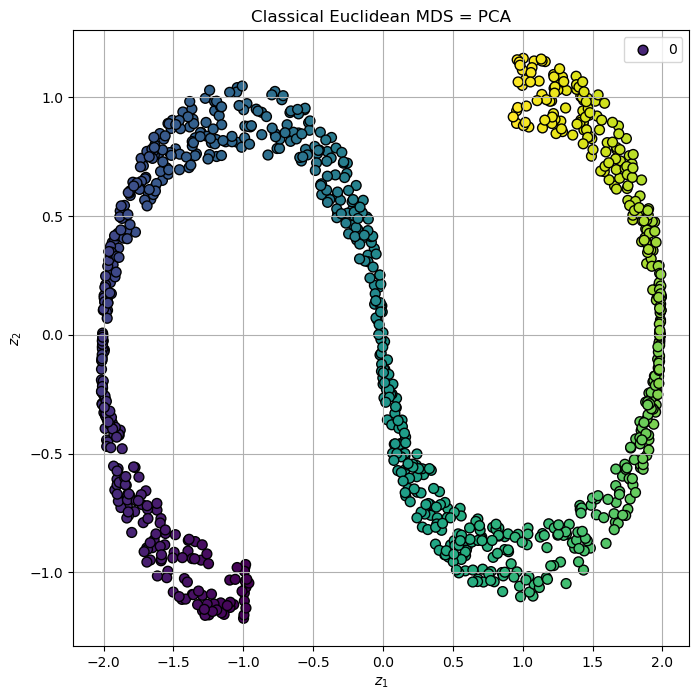

In [11]:
# Plot the Low Dimensional Data

hA = PlotScatterData3D(mZ1, vC = vC, axesProjection = None, figSize = (8, 8))
hA.set_xlabel('${{z}}_{{1}}$')
hA.set_ylabel('${{z}}_{{2}}$')
hA.set_box_aspect(1)
hA.set_title('Classical Euclidean MDS = PCA')

plt.show()

* <font color='brown'>(**#**)</font> The Non Metric MDS is guaranteed to keep the order of distances, but not the distance itself.

### Metric MDS

$$\min_{\left\{ \boldsymbol{z}_{i}\in\mathbb{R}^{d}\right\} }\sum_{i=1}^{N}\sum_{j=1}^{N}\left(d\left(\boldsymbol{x}_{i},\boldsymbol{x}_{j}\right)-\left\Vert \boldsymbol{z}_{i}-\boldsymbol{z}_{j}\right\Vert _{2}\right)^{2}$$

the above is not deterministic (It is a non convex optimization problem)!


In [12]:
# Apply MDS using SciKit Learn

oMdsDr = MDS(n_components = lowDim, dissimilarity = 'precomputed', normalized_stress = 'auto')
mZ2 = oMdsDr.fit_transform(mD)

* <font color='red'>(**?**)</font> Are the results deterministic in the case above?
* <font color='brown'>(**#**)</font> The Metric MDS tries to rebuild the data in low dimension with as similar as it can distance matrix. Yet it is not guaranteed to have the same distance.

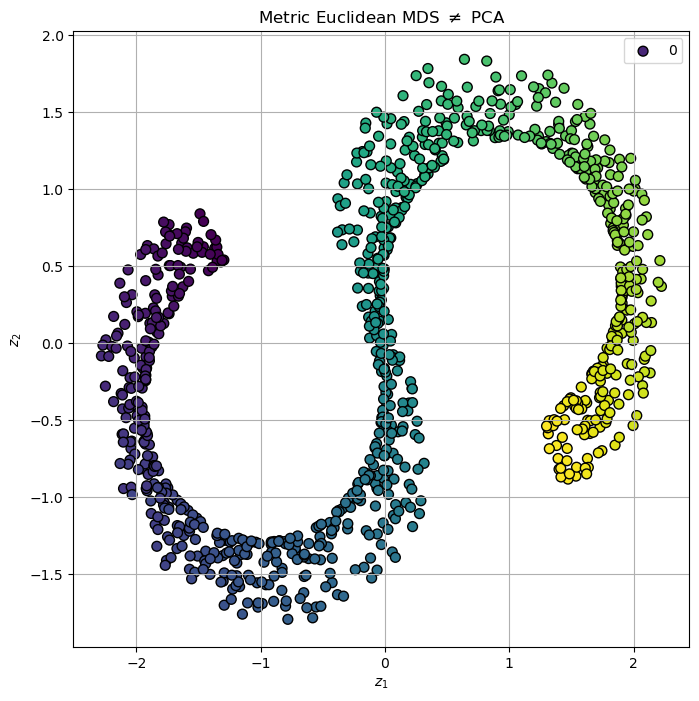

In [13]:
# Plot the Low Dimensional Data

hA = PlotScatterData3D(mZ2, vC = vC, axesProjection = None, figSize = (8, 8))
hA.set_xlabel('${{z}}_{{1}}$')
hA.set_ylabel('${{z}}_{{2}}$')
hA.set_box_aspect(1)
hA.set_title(r'Metric Euclidean MDS $\neq$ PCA')

plt.show()

### Metric MDS with Geodesic Distance

We have access to the geodesic distance using `vC`, the position along the "main" axis.

In [17]:
# Geodesic Distance

mGeodesicDist = sp.spatial.distance.squareform(sp.spatial.distance.pdist(np.c_[vC, mX[:, 1]]))
mZ3           = oMdsDr.fit_transform(mGeodesicDist)

* <font color='red'>(**?**)</font> Can we use the geodesic distance in real world?

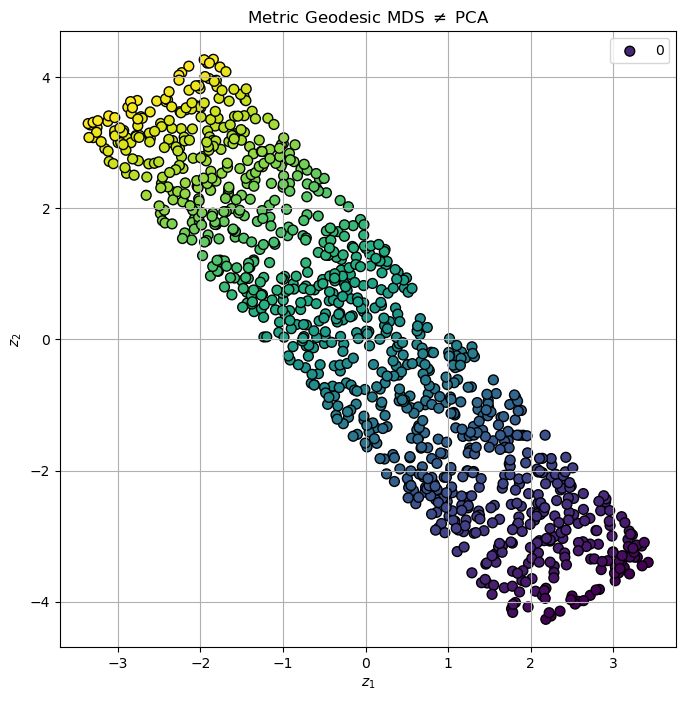

In [18]:
# Plot the Low Dimensional Data

hA = PlotScatterData3D(mZ3, vC = vC, axesProjection = None, figSize = (8, 8))
hA.set_xlabel('${{z}}_{{1}}$')
hA.set_ylabel('${{z}}_{{2}}$')
hA.set_box_aspect(1)
hA.set_title(r'Metric Geodesic MDS $\neq$ PCA')

plt.show()

* <font color='red'>(**?**)</font> Is the result above better than the previous ones? Why?